<center><span style='font-size: 25px;'>ПРЕДСКАЗАНИЕ УДОВЛЕТВОРЁННОСТИ КЛИЕНТОВ ПОЛЁТОМ</span></center>

<img src='data/pics/descr_1.png' width='70%' style='display:block; margin:auto;'>

Проект был сделан на `Python 3.12.7`

<h2 id='contents'>Оглавляшка:</h2>

0. [Загружаемые библиотеки](#libs)

<center><span style="font-size:25px;">Практика по бустингу</span></center> 

1. [Загрузка данных](#intro)
2. [Небольшое EDA и FE](#edafe)
    * [Избавление от пропусков](#ex_6_2)
    * [Кого в какой категории больше?](#ex_6_3)
    * [Кодирование категориальных признаков](#ex_6_4)
3. [Разбиение выборки на train и test](#ex_6_5)
4. [Масштабирование](#ex_6_6)
5. [Обучение простой логистической регрессии](#ex_6_7)
6. [AdaBoost](#ex_6_8)
7. [Градиентный бустинг через GridSearch](#ex_6_9)
8. [XGBoost](#ex_6_10)
9. [CatBoost](#ex_6_11)
10. [Confusion matrix для наилучшей модели](#ex_6_12)
11. [Важность признаков](#ex_6_13)

Доп. материалы:

<a href='https://catboost.ai/docs/en/concepts/python-reference_utils_get_confusion_matrix'>get_confusion_matrix из документации catboost</a>

## Загружаемые библиотеки<a id='libs'></a>

In [1]:
from data.functions_akialema import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import f1_score, classification_report, confusion_matrix

from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_confusion_matrix

plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

## Загрузка данных <a id='intro'></a>

In [2]:
df = pd.read_csv('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1QRlKSEAHcFpHI6BY_eHRJjcIQfgR-eZf', index_col=0)#.drop('id', axis=1)

my_info(df)

memory usage: 48.0 MB


,column,num of unique vals,type,mode,number of entries,NaN vals,number of dublics,describe
0,Customer Type,2,object,Loyal Customer,103904,0,0,see type column
1,Gender,2,object,Female,103904,0,0,see type column
2,Type of Travel,2,object,Business travel,103904,0,0,see type column
3,satisfaction,2,object,neutral or dissatisfied,103904,0,0,see type column
4,Class,3,object,Business,103904,0,0,see type column
5,Baggage handling,5,int64,4,103904,0,0,min...: 1.00max..: 5.00mean: 3.63std....: 1.18
6,Checkin service,6,int64,4,103904,0,0,min...: 0.00max..: 5.00mean: 3.30std....: 1.27
7,Cleanliness,6,int64,4,103904,0,0,min...: 0.00max..: 5.00mean: 3.29std....: 1.31
8,Departure/Arrival time convenient,6,int64,4,103904,0,0,min...: 0.00max..: 5.00mean: 3.06std....: 1.53
9,Ease of Online booking,6,int64,3,103904,0,0,min...: 0.00max..: 5.00mean: 2.76std....: 1.40


[↑ contents](#contents)

<h2 id='edafe'>Небольшое EDA и FE</h2>

<h3 id='ex_6_2'>Избавление от пропусков</h3>

Давайте избавимся от найденных пропусков. Заполните их все медианными значениями. После этого вычислите среднее арифметическое для признака, отражающего задержку при прибытии в минутах. Ответ округлите до двух знаков после точки-разделителя.

In [5]:
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median())

good_print('Вывести среднее арифметическое после заполнения пропусков.', round(df['Arrival Delay in Minutes'].mean(), 2))

Вывести среднее арифметическое после заполнения пропусков.
---------------------------------------------------------
Ответ: 15.13



[↑ contents](#contents)

<h3 id='ex_6_3'>ЕДА по таргету</h3>

Проведём небольшой разведывательный анализ. Посмотрим, в каких категориях пассажиров превалировали удовлетворённые полетом клиенты.

1. Сравните удовлетворённость полётом мужчин и женщин. Выберите верное утверждение:
    * Среди мужчин больше довольных, а среди женщин больше нейтрально настроенных/недовольных.
    * Среди женщин больше довольных, а среди мужчин больше нейтрально настроенных/недовольных.
    * В обеих категориях больше довольных.
    * <span style='color:lightgreen'>В обеих категориях больше нейтрально настроенных/недовольных</span>. 
2. Теперь сравним категории пассажиров в зависимости от их цели поездки. Выберите все верные утверждения:
    * <span style='color:lightgreen'>Среди тех, кто летал в деловую поездку, довольных больше, чем нейтрально настроенных/недовольных</span>.
    * Среди тех, кто летал в деловую поездку, довольных меньше, чем нейтрально настроенных/недовольных.
    * Среди тех, кто летал по личным делам, довольных больше, чем нейтрально настроенных/недовольных.
    * <span style='color:lightgreen'>Среди тех, кто летал по личным делам, довольных меньше, чем нейтрально настроенных/недовольных</span>. 
3. В каком туристическом классе наибольший процент довольных клиентов? <span style='color:lightgreen'>Business</span>


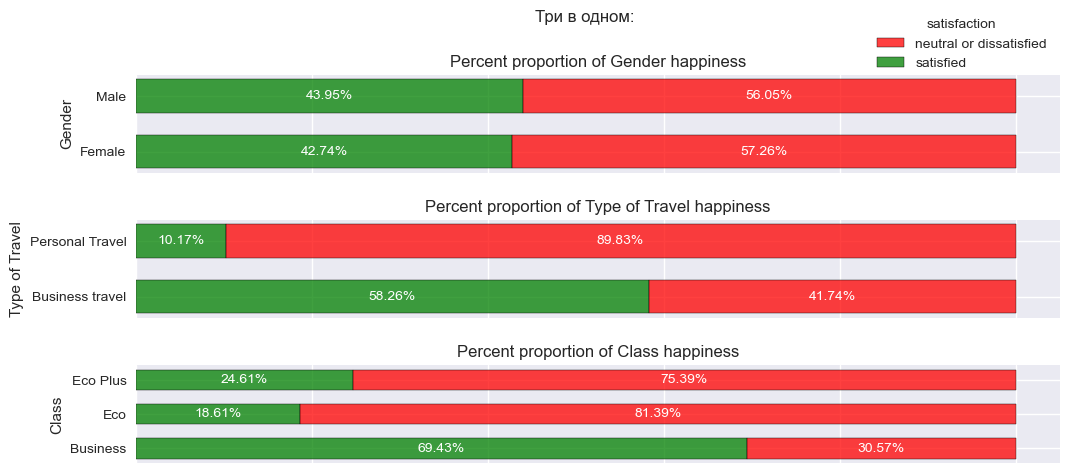

In [6]:
list_of_cols_for_ex = ['Gender', 'Type of Travel', 'Class']

fig, ax = plt.subplots(nrows=len(list_of_cols_for_ex), figsize=(10, 5))
fig.tight_layout(h_pad=2) # расстояние между подграфиками
plt.subplots_adjust(top=0.85) # чтобы заголовок не налезал на графики

for k, j in enumerate(list_of_cols_for_ex):

    df_for_loof = (df.groupby(j)['satisfaction'].value_counts(normalize=True) * 100).unstack().sort_values(j, ascending=False).reset_index().melt(id_vars=j, value_name='Percent')
    
    ax[k] = sns.histplot(data=df_for_loof, y=j, hue='satisfaction', weights='Percent', multiple='stack', palette=['red', 'green'], shrink=.6, ax=ax[k])
    [ax[k].bar_label(ax[k].containers[i], fmt="%.2f%%", label_type='center', color='white') for i in range(len(ax[k].containers))]

    ax[k].set(title=f'Percent proportion of {j} happiness', xlabel='', xticklabels='')
    if k > 0:
        ax[k].legend([])

ax[0].get_legend().set_bbox_to_anchor((1, 1.7))
ax[0].get_legend().set_loc("upper right")
plt.suptitle('Три в одном:')
plt.show('png')

[↑ contents](#contents)

<h3 id='ex_6_4'>Кодирование</h3>

Перекодируем часть бинарных признаков, чтобы использовать их при обучении.

Для остальных категориальных признаков создайте dummy-переменные. Сделайте это с помощью функции `get_dummies()` из библиотеки `Pandas`, параметры не меняйте. Сколько теперь признаков в данных (включая целевую переменную)?

In [7]:
df['satisfaction'] = df['satisfaction'].map({'neutral or dissatisfied':0 , 'satisfied':1})
df['Customer Type'] = df['Customer Type'].map({'Loyal Customer':1, 'disloyal Customer':0})
df['Type of Travel'] = df['Type of Travel'].map({'Personal Travel':0, 'Business travel':1})
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

df = pd.get_dummies(df, dtype=int)

good_print('Сколько признаков получилось после кодирования?', df.shape[1])

Сколько признаков получилось после кодирования?
----------------------------------------------
Ответ: 26



[↑ contents](#contents)

<h3 id='ex_6_5'>Разбиение выборки на train и test</h3>

Разбейте данные на обучающую и тестовую выборки в соотношении `80/20`, параметр `random_state = 26`. Сколько наблюдений попало в тестовую выборку?

Какой размер тестовой выборки?
-----------------------------
Ответ: 20781



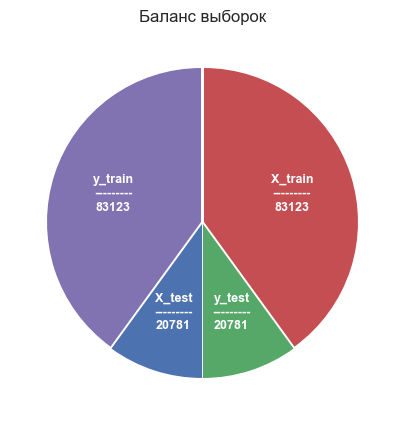

In [8]:
X = df.drop('satisfaction', axis=1)
y = df['satisfaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

good_print('Какой размер тестовой выборки?', X_test.shape[0])
plot_train_test_split_balance(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, startangle=234).show('png')

[↑ contents](#contents)

<h3 id='ex_6_6'>Масштабирование</h3>

Теперь нам необходимо реализовать масштабирование данных. Для этого обучите на обучающей выборке метод `StandardScaler()` и с помощью него преобразуйте и обучающую, и тестовую выборки. Не забудьте, что целевую переменную обрабатывать не нужно.

В качестве ответа введите самое первое значение из матрицы преобразованных признаков тестовой выборки. Округлите значение до двух знаков после точки-разделителя.

P.S. Масштабирование типа для сравнения разных моделей, т.к. некоторым из моделей оно нужно.

In [9]:
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

good_print('Вывести первое значение прошкалированной тестовой матрицы.', f"{X_test_scaled[0][0]:.2f}")

Вывести первое значение прошкалированной тестовой матрицы.
---------------------------------------------------------
Ответ: 0.94



[↑ contents](#contents)

<h3 id='ex_6_7'>Обучение простой логистической регрессии</h3>

Перейдём к обучению моделей. В качестве первой модели возьмём самую простую — `логистическую регрессию`. Мы делаем это для того, чтобы потом сравнивать с ней полученные результаты: так вы сможете выяснить, насколько ансамбли смогут улучшить точность прогноза.

Обучите логистическую регрессию с параметрами по умолчанию на наших данных. В качестве ответа введите значение метрики `f1_score`. Ответ округлите до трёх знаков после точки-разделителя.

In [10]:
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

good_print('Вывести f1 для логистической регрессии.', f"{f1_score(y_test, logreg.predict(X_test_scaled)):.3f}")

Вывести f1 для логистической регрессии.
--------------------------------------
Ответ: 0.855



[↑ contents](#contents)

<h3 id='ex_6_8'>Adaboost</h3>

Теперь перейдём к бустингу. Начнём с обучения первой модели — `AdaBoost`. В качестве базовой модели для неё возьмите решающее дерево с параметром `random_state = 26`.

Обучите `AdaBoost`, зафиксировав `random_state` со значением `26` и задав `темп обучения 0.01`. В качестве ответа введите значение метрики `f1_score`. Ответ округлите до трёх знаков после точки-разделителя.

In [11]:
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=26), learning_rate=0.1, random_state=26, algorithm='SAMME')
ada.fit(X_train_scaled, y_train)

good_print('Вывести f1 для AdaBoost.', f"{f1_score(y_test, ada.predict(X_test_scaled)):.3f}")

Вывести f1 для AdaBoost.
-----------------------
Ответ: 0.941



[↑ contents](#contents)

<h3 id='ex_6_9'>Задание 6.9: Градиентный бустинг через GridSearch</h3>

Перейдем к следующему алгоритму — градиентному бустингу.

Будем настраивать количество деревьев и темп обучения, делая перебор по следующей сетке:

>params = {"n_estimators":2**np.arange(8), "learning_rate":0.1**np.arange(3)}

Используйте для поиска оптимальных параметров `GridSearchCV`, а для ускорения работы алгоритма задайте параметр `кросс-валидации, равный 3`.

Какое наибольшее значение метрики `f1_score` получилось? Ответ округлите до трёх знаков после точки-разделителя.  
(Примечание. Необходимо указать лучший результат в методе `GridSearchCV` на тренировочных данных.)

In [12]:
params = {"n_estimators": 2**np.arange(8), "learning_rate": 0.1**np.arange(3)}

gb_gs = GridSearchCV(estimator=GradientBoostingClassifier(),
                     param_grid=params,
                     cv=3,
                     scoring='f1',
                     n_jobs=-1)
gb_gs.fit(X_train_scaled, y_train)

good_print('Вывести .best_score_ для GradientBoosting через GridSearch.', f"{gb_gs.best_score_:.3f}")

Вывести .best_score_ для GradientBoosting через GridSearch.
----------------------------------------------------------
Ответ: 0.949



[↑ contents](#contents)

<h3 id='ex_6_10'>XGBoost</h3>

Обучите алгоритм `XGBoost`. Так как он достаточно мощный «из коробки», определите его с параметрами по умолчанию, только задайте `random_state = 26`. Какое значение метрики `f1_score` получилось? Ответ округлите до трёх знаков после точки-разделителя.

In [13]:
xgb = XGBClassifier(random_state=26)
xgb.fit(X_train_scaled, y_train)

good_print('Вывести f1 для XGBoost.', f"{f1_score(y_test, xgb.predict(X_test_scaled)):.3f}")

Вывести f1 для XGBoost.
----------------------
Ответ: 0.957



[↑ contents](#contents)

<h3 id='ex_6_11'>CatBoost</h3>

Обучите алгоритм `CatBoost`. Как и `XGBoost`, будем обучать его с настройками по умолчанию и заданным `random_state = 26`. Какое значение метрики `f1_score` получилось? Ответ округлите до трёх знаков после точки-разделителя.

In [14]:
cat = CatBoostClassifier(random_state=26, verbose=False, allow_writing_files=False)
cat.fit(X_train_scaled, y_train)

good_print('Вывести f1 для CatBoost.', f"{f1_score(y_test, cat.predict(X_test_scaled)):.3f}")

Вывести f1 для CatBoost.
-----------------------
Ответ: 0.960



[↑ contents](#contents)

<h3 id='ex_6_12'>Confusion matrix для наилучшей модели</h3>

<img src='data/pics/conf_mat.png' width='70%' style='display:block; margin:auto' />

In [15]:
print('Вывести конф матрицу для тренировочной выборки:')
pd.DataFrame(np.round((get_confusion_matrix(cat, Pool(X_train_scaled, y_train)) / X_train.shape[0] * 100)))

Вывести конф матрицу для тренировочной выборки:


,0,1
0,56.0,1.0
1,2.0,42.0


[↑ contents](#contents)

<h3 id='ex_6_13'>Важность признаков</h3>

Оцените важность признаков для модели из предыдущего задания. Отметьте признак, который оказывает наибольшее влияние на значение целевой переменной:

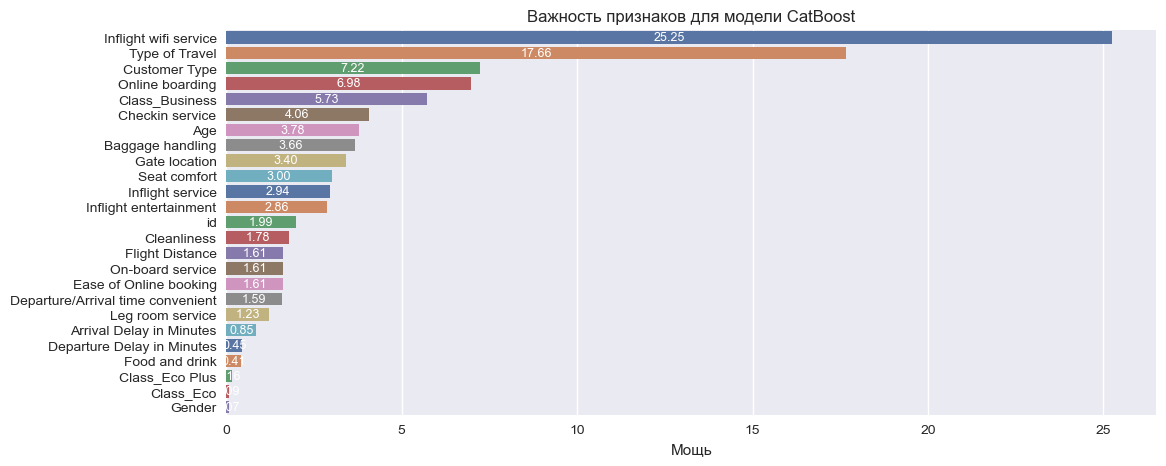

In [16]:
df_for_this_cell = pd.DataFrame([X_train.columns, cat.feature_importances_]).T.sort_values(by=1, ascending=False)

fig, ax = plt.subplots(figsize=(12, 5))
ax = sns.barplot(df_for_this_cell, x=1, y=0, hue=0, palette='deep')
ax.set(ylabel='', xlabel='Мощь', title='Важность признаков для модели CatBoost')
[ax.bar_label(ax.containers[i], fmt="%.2f", fontsize=9, label_type='center', color='white') for i in range(len(ax.containers))]
plt.show('png')

[↑ contents](#contents)